Taylor Salo

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import math
import pylab as plt
import seaborn as sns
import pandas as pd

# Import necessary objects from brian2
from brian2 import mV, ms, nsiemens, Mohm, nS, pamp
from brian2 import amp, siemens, volt
from brian2 import NeuronGroup, TimedArray, Synapses
from brian2 import SpikeMonitor
from brian2 import start_scope, store, restore, run

sns.set_style('darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
# Local functions
def update_critic(S, V, rw, eta):
    """
    Updates critic using stimulus (S), current (V),
    reward value (rw), and learning rate (eta).
    """
    RPE = rw-np.sum(S*V)
    delta_V = S*eta*RPE
    V = V + delta_V
    return RPE, V


def print_trial_info(trial, presented_stimulus, choice, rw, RPE, V, W):
    stim_string = ['green','red']
    print 'Trial #'+str(trial)
    print 'Presented stimulus: '+stim_string[presented_stimulus]
    print 'Choice: '+stim_string[choice]
    print 'Reward: '+str(rw)
    print 'RPE: ' +str(RPE)
    print 'Updated reward values:'+str(V)
    print 'Updated synaptic weights: '+str(W)+'\n'

In [3]:
start_scope()

# Settings for basic model
# define equations for the AdEx model (include noise)
# and equations for the AMPA and GABA synapse models
eqs =  '''
du/dt = ( -(u - u_rest) + delta_T*exp((u-vartheta_rh)/delta_T) +\
        R*(I - w - I_AMPA - I_GABA) ) / tau_m +\
        sigma*xi*tau_m**-0.5 : volt
dw/dt = (a*(u - u_rest) - w)/tau_w : amp
I = input_current(t,i) : amp
I_AMPA = g_AMPA*(u - E_AMPA): amp
I_GABA = g_GABA*(u - E_GABA): amp
dg_AMPA/dt = -g_AMPA / tau_AMPA : siemens
dg_GABA/dt = -g_GABA / tau_GABA : siemens
'''

# AMPA synapses
E_AMPA = 0 * mV  # equilibrium potential of the channel
tau_AMPA = 2 * ms  # speed of NT unbinding
AMPA_jump = 200*nsiemens  # jump in conductivity for excitatory

# GABA synapses
E_GABA = -70 * mV  # equilibrium potential of the channel
tau_GABA = 6 * ms  # speed of NT unbinding
GABA_jump = 80*nsiemens  # jump in conductivity for inhibitory synapse

# create Visual Cortex (input) neuron group
RSN = NeuronGroup(2, eqs, threshold='u>theta_reset',
      reset='u=u_r; w+= b', method='euler', dt=1*ms)

# define parameters of the RSN AdEx model
RSN.namespace['R'] = 200*Mohm  # membrane resistance
RSN.namespace['tau_m'] = 24*ms  # membrane time constant
RSN.namespace['theta_reset'] = 35*mV  # reset threshold
RSN.namespace['u_rest'] = -65*mV  # resting potential
RSN.namespace['u_r'] = -55*mV  # reset potential
RSN.namespace['vartheta_rh'] = -52*mV  # rheobase threshold
RSN.namespace['delta_T'] = 0.8*mV  # sharpness of the action potential
RSN.namespace['tau_w'] = 88*ms  # adaptation time constant
RSN.namespace['a'] = -0.8*nS  # subthreshold adaptation constant
RSN.namespace['b'] = 65*pamp  # adaptation jump after a spike
RSN.namespace['sigma'] = 0*mV  # amplitude of noise added to model

# set initial potential to u_rest
# use the variable in this model's namespace (see below)
RSN.u[:] = -65*mV

# set initial adaptation to zero
RSN.w[:] = 0

# Manual input to this model (zeros for now)
input_current = np.zeros((2000,2))
input_current = TimedArray(input_current*pamp, dt=1*ms)
RSN.namespace['input_current'] = input_current

# let's get rid of input_current to avoid namespace warnings
del input_current

# create neuron group
MSN = NeuronGroup(2, eqs, threshold='u>theta_reset',
      reset='u=u_r; w+= b', method='euler', dt=1*ms)

# define parameters of the RSN AdEx model
MSN.namespace['R'] = 31.5*Mohm  # membrane resistance
MSN.namespace['tau_m'] = 50*ms  # membrane time constant
MSN.namespace['theta_reset'] = 40*mV  # reset threshold
MSN.namespace['u_rest'] = -80*mV  # resting potential
MSN.namespace['u_r'] = -55*mV  # reset potential
MSN.namespace['vartheta_rh'] = -55*mV  # rheobase threshold
MSN.namespace['delta_T'] = 2*mV  # sharpness of the action potential
MSN.namespace['tau_w'] = 100*ms  # adaptation time constant
MSN.namespace['a'] = -20*nS  # subthreshold adaptation constant
MSN.namespace['b'] = 150*pamp  # adaptation jump after a spike
MSN.namespace['sigma'] = 5*mV  # amplitude of noise added to model

# set initial potential to u_rest
# use the variable in this model's namespace (see below)
MSN.u[:] = -80*mV

# set initial adaptation to zero
MSN.w[:] = 0

# Manual input to this model is all zeros
input_current = np.zeros((2000,4))
input_current = TimedArray(input_current*pamp, dt=1*ms)
MSN.namespace['input_current'] = input_current

# let's get rid of input_current to avoid namespace warnings
del input_current

# create excitatory synapses
E = Synapses(RSN, MSN, 'W : 1', on_pre='g_AMPA += AMPA_jump*W', dt=1*ms)
E.connect(i=0, j=0)
E.connect(i=1, j=1)
E.connect(i=0, j=1)
E.connect(i=1, j=0)

# create inhibitory synapses
I = Synapses(MSN, on_pre='g_GABA += GABA_jump', dt=1*ms)
I.connect(i=0, j=1)
I.connect(i=1, j=0)

# Set initial values for learner
# Start array V at zero
V = np.array([0, 0])

# Set learning rate
eta = 0.2

# indicate what to record
spikes_RSN = SpikeMonitor(RSN)
spikes_MSN = SpikeMonitor(MSN)

# store the model
store(name='save')

# Question 1

In [4]:
n_trials = 100
prepost_results = [[] for _ in range(n_trials)]

run_W = np.array([0.3, 0.3, 0.3, 0.3])
trial = 0
while trial < n_trials:
    restore(name='save')

    # Set weights
    E.W = run_W
    
    # variable determines what stimulus is presented
    # 0=green, 1=red
    presented_stimulus = np.random.randint(2)

    # set up manual input to RSNs (changes in "green" vs. "red" trials)
    # see PT05 and HW4 for details
    trial_input = np.zeros((2000,2))
    trial_input[:, presented_stimulus] = 400
    trial_input = TimedArray(trial_input*pamp, dt=1*ms)
    RSN.namespace['input_current'] = trial_input

    # run the simulation for 2 s
    run(2000*ms)

    # calculate RT and choice
    try:
        RT = 100 + 1000*np.amin([spikes_MSN.t[spikes_MSN.i==0][4],
              spikes_MSN.t[spikes_MSN.i==1][4]])
        choice = np.argmin([spikes_MSN.t[spikes_MSN.i==0][4],
              spikes_MSN.t[spikes_MSN.i==1][4]])
    except:
        continue

    # determine whether a reward is given
    if (choice==presented_stimulus):
        rw = 1
    else:
        rw = 0
    
    prepost_results[trial] = ['Pre-Learning', rw, RT]
    
    trial += 1

In [5]:
accs = np.array([t[1] for t in prepost_results])
avg_acc = np.mean(accs)
print('Proportion of correct responses: {0}'.format(avg_acc))

Proportion of correct responses: 0.51


# Question 2

In [6]:
n_trials = 160
RT_dur = np.zeros((n_trials))
acc_dur = np.zeros((n_trials))
rpes = np.zeros((n_trials))
vs = np.zeros((n_trials, 2))
ws = np.zeros((n_trials, 4))

run_W = np.array([0.3, 0.3, 0.3, 0.3])
trial = 0
while trial < n_trials:
    restore(name='save')

    # Set weights
    E.W = run_W
    
    # variable determines what stimulus is presented
    # 0=green, 1=red
    presented_stimulus = np.random.randint(2)

    # set up manual input to RSNs (changes in "green" vs. "red" trials)
    # see PT05 and HW4 for details
    trial_input = np.zeros((2000,2))
    trial_input[:, presented_stimulus] = 400
    trial_input = TimedArray(trial_input*pamp, dt=1*ms)
    RSN.namespace['input_current'] = trial_input

    # run the simulation for 2 s
    run(2000*ms)

    # calculate RT and choice
    try:
        RT = 100 + 1000*np.amin([spikes_MSN.t[spikes_MSN.i==0][4],
              spikes_MSN.t[spikes_MSN.i==1][4]])
        choice = np.argmin([spikes_MSN.t[spikes_MSN.i==0][4],
              spikes_MSN.t[spikes_MSN.i==1][4]])
    except:
        continue

    # determine whether a reward is given
    if (choice==presented_stimulus):
        rw = 1
    else:
        rw = 0

    # Create the array S
    S = np.zeros(2)
    S[presented_stimulus] = 1
    RPE, V = update_critic(S, V, rw, eta)

    # Compute activity variables for RSNs
    RSN_A = np.zeros(4)
    RSN_A[[0, 2]] = spikes_RSN.count[0] / 120
    RSN_A[[1, 3]] = spikes_RSN.count[1] / 120

    # Compute activity variables for MSNs
    MSN_A = np.zeros(4)
    MSN_A[[0, 3]] = spikes_MSN.count[0] / 50
    MSN_A[[1, 2]] = spikes_MSN.count[1] / 50

    # apply update rule
    alpha = 0.3
    run_W += alpha * RSN_A * MSN_A * RPE

    RT_dur[trial] = RT
    acc_dur[trial] = rw
    rpes[trial] = RPE
    vs[trial, :] = V
    ws[trial, :] = run_W
    
    print_trial_info(trial, presented_stimulus, choice, rw, RPE, V, run_W)
    trial += 1

learned_W = run_W

Trial #0
Presented stimulus: green
Choice: green
Reward: 1
RPE: 1.0
Updated reward values:[ 0.2  0. ]
Updated synaptic weights: [ 0.3666  0.3     0.3444  0.3   ]

Trial #1
Presented stimulus: red
Choice: green
Reward: 0
RPE: 0.0
Updated reward values:[ 0.2  0. ]
Updated synaptic weights: [ 0.3666  0.3     0.3444  0.3   ]

Trial #2
Presented stimulus: red
Choice: green
Reward: 0
RPE: 0.0
Updated reward values:[ 0.2  0. ]
Updated synaptic weights: [ 0.3666  0.3     0.3444  0.3   ]

Trial #3
Presented stimulus: green
Choice: red
Reward: 0
RPE: -0.2
Updated reward values:[ 0.16  0.  ]
Updated synaptic weights: [ 0.34662  0.3      0.32664  0.3    ]

Trial #4
Presented stimulus: red
Choice: red
Reward: 1
RPE: 1.0
Updated reward values:[ 0.16  0.2 ]
Updated synaptic weights: [ 0.34662  0.36105  0.32664  0.33885]

Trial #5
Presented stimulus: green
Choice: red
Reward: 0
RPE: -0.16
Updated reward values:[ 0.128  0.2  ]
Updated synaptic weights: [ 0.335076  0.36105   0.312432  0.33885 ]

Trial #

## Question 2 Part A

WARNING    /Users/salo/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
 [py.warnings]


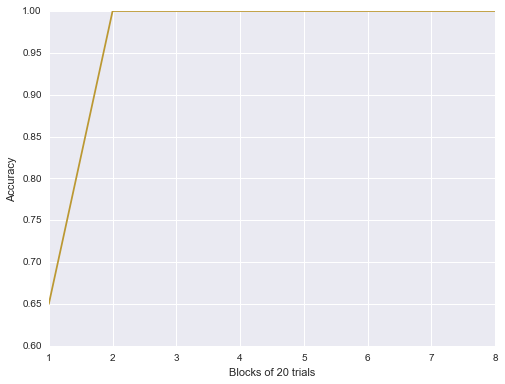

In [7]:
# Plot accuracy
fig, ax = plt.subplots()
binned_acc = []
for i in range(8):
    binned_acc.append(np.mean(acc_dur[i*20:(i+1)*20]))

ax.plot(range(1, 9), binned_acc, color=sns.color_palette('husl')[1])
ax.set_xlabel('Blocks of 20 trials')
ax.set_ylabel('Accuracy')

fig.show()

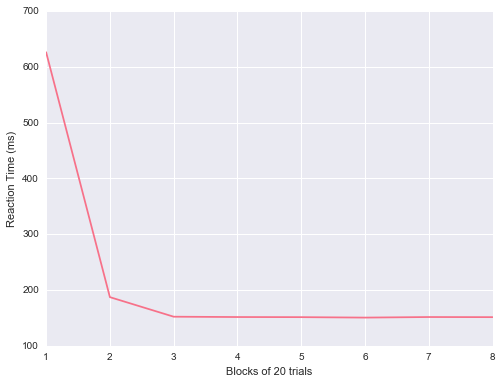

In [8]:
# Plot RT
fig, ax = plt.subplots()
binned_RT = []
for i in range(8):
    binned_RT.append(np.mean(RT_dur[i*20:(i+1)*20]))

ax.plot(range(1, 9), binned_RT)
ax.set_xlabel('Blocks of 20 trials')
ax.set_ylabel('Reaction Time (ms)')

fig.show()

Accuracy increases and reaction time decreases over the course of learning. Both appear to be approaching an asymptote (1 for acc and ~150 for RT). Both accuracy and RT reach their asymptotes at the same time (bin 2).

## Question 2 Part B

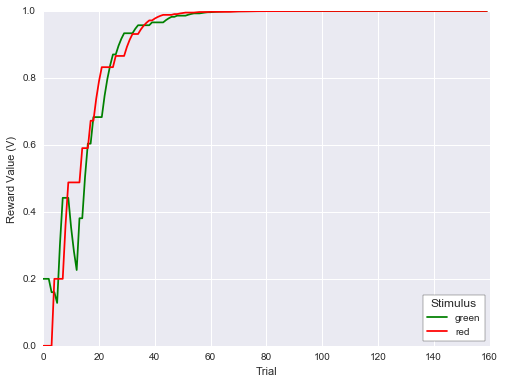

In [9]:
# Plot V
fig, ax = plt.subplots()
ax.plot(range(len(vs)), vs[:, 0], label='green', c='g')
ax.plot(range(len(vs)), vs[:, 1], label='red', c='r')

ax.set_xlabel('Trial')
ax.set_ylabel('Reward Value (V)')

legend = ax.legend(frameon=True, title='Stimulus', loc='lower right')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

fig.show()

The learning curves are different here in that they noisier than the ones in the Programming Tutorial. Additionally, in the programming tutorial, only one stimulus was presented, so only one V curve increased and plateaued. In this case, both stimuli are presented at one point or another, so reward values increase and plateau for both stimuli.

## Question 2 Part C

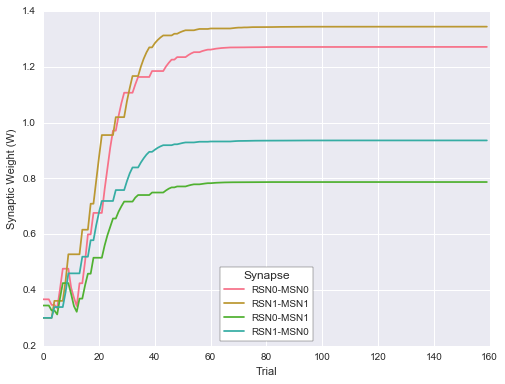

In [10]:
# Plot W
fig, ax = plt.subplots()

ax.plot(range(len(ws)), ws[:, 0], label='RSN0-MSN0', color=sns.color_palette('husl')[0])
ax.plot(range(len(ws)), ws[:, 1], label='RSN1-MSN1', color=sns.color_palette('husl')[1])
ax.plot(range(len(ws)), ws[:, 2], label='RSN0-MSN1', color=sns.color_palette('husl')[2])
ax.plot(range(len(ws)), ws[:, 3], label='RSN1-MSN0', color=sns.color_palette('husl')[3])

ax.set_xlabel('Trial')
ax.set_ylabel('Synaptic Weight (W)')

legend = ax.legend(frameon=True, title='Synapse', loc='lower center')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

fig.show()

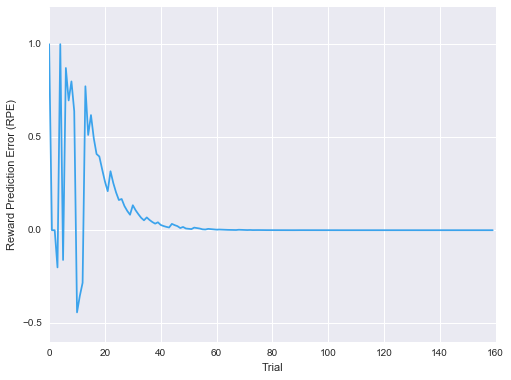

In [11]:
# Plot RPE
fig, ax = plt.subplots()
ax.plot(range(len(rpes)), rpes, label='RPE', color=sns.color_palette('husl')[4])

ax.set_xlabel('Trial')
ax.set_ylabel('Reward Prediction Error (RPE)')

fig.show()

Reward prediction error directs learning, and thus affects reward value (V) and synaptic weights (W), based on performance. In this case, RPE decreases to zero over the course of learning, which is reflected in the manner in which the V and W curves plateau (with V approaching 1 and the W values approaching stable synaptic weights for the strong and weak synapses), at about trial 40. When RPE is different from zero, learning will occur, which will result in a change in synaptic weight and in reward value.  
Learning seems to slow down and eventually stop at around trial 40, because the system is accurately predicting reward nearly perfectly at this time.

# Question 3

In [12]:
n_trials = 100

run_W = learned_W
trial = 0
while trial < n_trials:
    restore(name='save')

    # Set weights
    E.W = run_W
    
    # variable determines what stimulus is presented
    # 0=green, 1=red
    presented_stimulus = np.random.randint(2)

    # set up manual input to RSNs (changes in "green" vs. "red" trials)
    # see PT05 and HW4 for details
    trial_input = np.zeros((2000,2))
    trial_input[:, presented_stimulus] = 400
    trial_input = TimedArray(trial_input*pamp, dt=1*ms)
    RSN.namespace['input_current'] = trial_input

    # run the simulation for 2 s
    run(2000*ms)

    # calculate RT and choice
    try:
        RT = 100 + 1000*np.amin([spikes_MSN.t[spikes_MSN.i==0][4],
              spikes_MSN.t[spikes_MSN.i==1][4]])
        choice = np.argmin([spikes_MSN.t[spikes_MSN.i==0][4],
              spikes_MSN.t[spikes_MSN.i==1][4]])
    except:
        continue

    # determine whether a reward is given
    if (choice==presented_stimulus):
        rw = 1
    else:
        rw = 0
    
    prepost_results.append(['Post-Learning', rw, RT])
    
    trial += 1

res_df = pd.DataFrame(data=prepost_results, columns=['Timepoint', 'Accuracy', 'RT'])

WARNING    "i" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "i" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


## Question 3 Part A

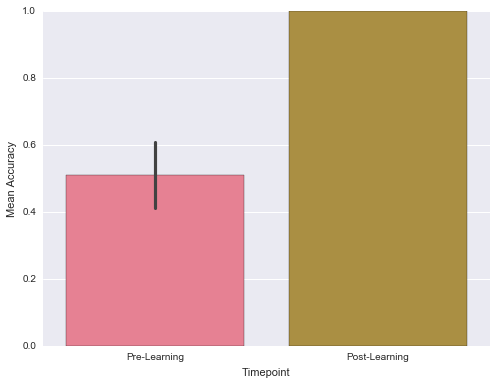

In [13]:
# Bar plot of average accuracy before and after learning.
fig, ax = plt.subplots()
sns.barplot(y="Accuracy", x="Timepoint", data=res_df, ax=ax)
ax.set_ylabel('Mean Accuracy')
fig.show()

The average accuracy increases from ~50% (chance) before learning to 100% (perfect accuracy) after learning. 

## Question 3 Part B

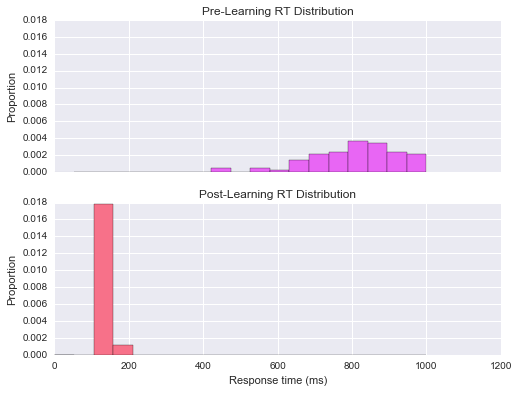

In [14]:
bins = np.linspace(0, 1000, 20)

fig, axes = plt.subplots(2, sharex=True, sharey=True)
axes[0].hist(res_df['RT'].loc[res_df['Timepoint']=='Pre-Learning'], bins,
         normed=True, facecolor=sns.color_palette('husl')[5],
         edgecolor='black')
axes[0].set_ylabel('Proportion')
axes[0].set_title('Pre-Learning RT Distribution')

axes[1].hist(res_df['RT'].loc[res_df['Timepoint']=='Post-Learning'], bins,
         normed=True, facecolor=sns.color_palette('husl')[0],
         edgecolor='black')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Response time (ms)')
axes[1].set_title('Post-Learning RT Distribution')
fig.show()

In [15]:
rpes

array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.00000000e-01,   1.00000000e+00,  -1.60000000e-01,
         8.72000000e-01,   6.97600000e-01,   8.00000000e-01,
         6.40000000e-01,  -4.41920000e-01,  -3.53536000e-01,
        -2.82828800e-01,   7.73736960e-01,   5.12000000e-01,
         6.18989568e-01,   4.95191654e-01,   4.09600000e-01,
         3.96153324e-01,   3.27680000e-01,   2.62144000e-01,
         2.09715200e-01,   3.16922659e-01,   2.53538127e-01,
         2.02830502e-01,   1.62264401e-01,   1.67772160e-01,
         1.29811521e-01,   1.03849217e-01,   8.30793735e-02,
         1.34217728e-01,   1.07374182e-01,   8.58993459e-02,
         6.64634988e-02,   5.31707990e-02,   6.87194767e-02,
         5.49755814e-02,   4.39804651e-02,   3.51843721e-02,
         4.25366392e-02,   2.81474977e-02,   2.25179981e-02,
         1.80143985e-02,   1.44115188e-02,   3.40293114e-02,
         2.72234491e-02,   2.17787593e-02,   1.15292150e-02,
         1.74230074e-02,

Learning decreases the average reaction time significantly. It also decreases the dispersion of RTs, meaning that RT varies less between trials after learning than before learning.